In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [6]:
runs = [304125,302263,304508]
cnorm = 8
with open("good_data_CNorm"+str(cnorm)+".pickle", 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 1


1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224


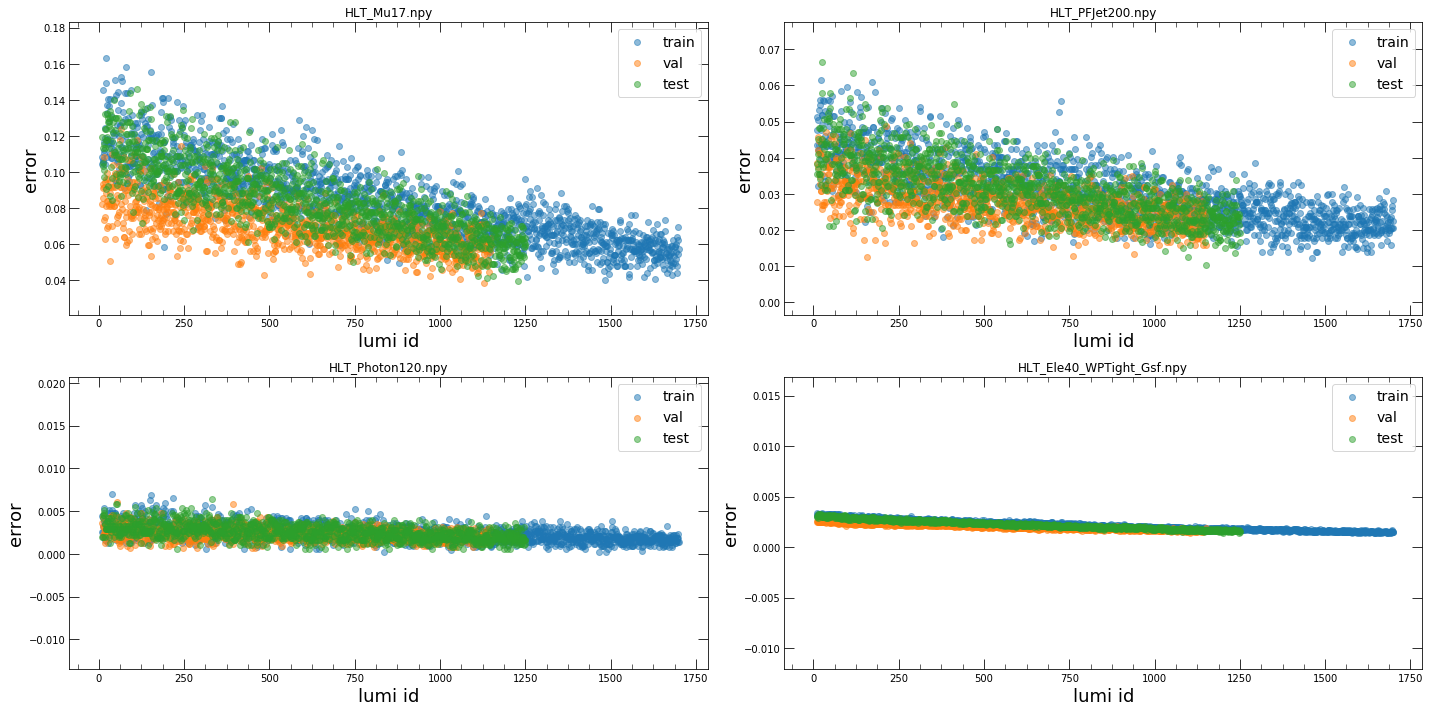

In [7]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [8]:
model_name = "simplest_" + str(cnorm)

In [9]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 15        
_________________________________________________________________
reconstructed (Dense)        (None, 4)                 16        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1129 samples
Epoch 1/1000
 - 0s - loss: 0.1126 - val_loss: 0.0795
Epoch 2/1000
 - 0s - loss: 0.1100 - val_loss: 0.0775
Epoch 3/1000
 - 0s - loss: 0.1072 - val_loss: 0.0755
Epoch 4/1000
 - 0s - loss: 0.1045 - val_loss: 0.0736
Epoch 5/1000
 - 0s - loss: 0.1017 - val_loss: 0.0716
Epoch 6/1000
 - 0s - loss: 0.0991 - val_loss: 0.0698
Epoch 7/1000
 - 0s - loss: 0.0965 - val_loss: 0.0679
Epoch 8/1000
 - 0s - loss: 0.0939 - val_loss: 0.0661
Epoch 9/1000
 - 0s - loss: 0.0915 - val_loss: 0.0644
Epoch 10/1000
 - 0s - loss: 0.0890 - val_loss: 0.0627
Epoch 11/1000
 - 0s - loss: 0.0867 - val_loss: 0.0610
Epoch 12/1000
 - 0s - loss: 0.0844 - val_loss: 0.0594
Epoch 13/1000
 - 0s - loss: 0.0821 - val_loss: 0.0578
Epoch 14/1000
 - 0s - loss: 0.0800 - val_loss: 0.0563
Epoch 15/1000
 - 0s - loss: 0.0778 - val_loss: 0.0548
Epoch 16/1000
 - 0s - loss: 0.0758 - val_loss: 0.0533
Epoch 17/1000
 - 0s - loss: 0.0738 - val_loss: 0.0519
Epoch 18/1000
 - 0s - loss: 0.0718 - val_lo

 - 0s - loss: 0.0048 - val_loss: 0.0034
Epoch 152/1000
 - 0s - loss: 0.0047 - val_loss: 0.0033
Epoch 153/1000
 - 0s - loss: 0.0046 - val_loss: 0.0033
Epoch 154/1000
 - 0s - loss: 0.0045 - val_loss: 0.0032
Epoch 155/1000
 - 0s - loss: 0.0045 - val_loss: 0.0032
Epoch 156/1000
 - 0s - loss: 0.0044 - val_loss: 0.0031
Epoch 157/1000
 - 0s - loss: 0.0044 - val_loss: 0.0031
Epoch 158/1000
 - 0s - loss: 0.0043 - val_loss: 0.0030
Epoch 159/1000
 - 0s - loss: 0.0042 - val_loss: 0.0030
Epoch 160/1000
 - 0s - loss: 0.0042 - val_loss: 0.0029
Epoch 161/1000
 - 0s - loss: 0.0041 - val_loss: 0.0029
Epoch 162/1000
 - 0s - loss: 0.0040 - val_loss: 0.0029
Epoch 163/1000
 - 0s - loss: 0.0040 - val_loss: 0.0028
Epoch 164/1000
 - 0s - loss: 0.0039 - val_loss: 0.0028
Epoch 165/1000
 - 0s - loss: 0.0039 - val_loss: 0.0027
Epoch 166/1000
 - 0s - loss: 0.0038 - val_loss: 0.0027
Epoch 167/1000
 - 0s - loss: 0.0038 - val_loss: 0.0027
Epoch 168/1000
 - 0s - loss: 0.0037 - val_loss: 0.0026
Epoch 169/1000
 - 0s - lo

Epoch 296/1000
 - 0s - loss: 8.6949e-04 - val_loss: 6.0471e-04
Epoch 297/1000
 - 0s - loss: 8.6120e-04 - val_loss: 5.9893e-04
Epoch 298/1000
 - 0s - loss: 8.5307e-04 - val_loss: 5.9321e-04
Epoch 299/1000
 - 0s - loss: 8.4503e-04 - val_loss: 5.8756e-04
Epoch 300/1000
 - 0s - loss: 8.3701e-04 - val_loss: 5.8198e-04
Epoch 301/1000
 - 0s - loss: 8.2912e-04 - val_loss: 5.7645e-04
Epoch 302/1000
 - 0s - loss: 8.2138e-04 - val_loss: 5.7099e-04
Epoch 303/1000
 - 0s - loss: 8.1367e-04 - val_loss: 5.6559e-04
Epoch 304/1000
 - 0s - loss: 8.0601e-04 - val_loss: 5.6025e-04
Epoch 305/1000
 - 0s - loss: 7.9854e-04 - val_loss: 5.5497e-04
Epoch 306/1000
 - 0s - loss: 7.9107e-04 - val_loss: 5.4975e-04
Epoch 307/1000
 - 0s - loss: 7.8371e-04 - val_loss: 5.4460e-04
Epoch 308/1000
 - 0s - loss: 7.7646e-04 - val_loss: 5.3950e-04
Epoch 309/1000
 - 0s - loss: 7.6924e-04 - val_loss: 5.3446e-04
Epoch 310/1000
 - 0s - loss: 7.6214e-04 - val_loss: 5.2948e-04
Epoch 311/1000
 - 0s - loss: 7.5509e-04 - val_loss: 5.2

 - 0s - loss: 2.8926e-04 - val_loss: 1.9950e-04
Epoch 427/1000
 - 0s - loss: 2.8710e-04 - val_loss: 1.9800e-04
Epoch 428/1000
 - 0s - loss: 2.8494e-04 - val_loss: 1.9651e-04
Epoch 429/1000
 - 0s - loss: 2.8282e-04 - val_loss: 1.9503e-04
Epoch 430/1000
 - 0s - loss: 2.8071e-04 - val_loss: 1.9357e-04
Epoch 431/1000
 - 0s - loss: 2.7862e-04 - val_loss: 1.9211e-04
Epoch 432/1000
 - 0s - loss: 2.7655e-04 - val_loss: 1.9068e-04
Epoch 433/1000
 - 0s - loss: 2.7450e-04 - val_loss: 1.8925e-04
Epoch 434/1000
 - 0s - loss: 2.7246e-04 - val_loss: 1.8784e-04
Epoch 435/1000
 - 0s - loss: 2.7045e-04 - val_loss: 1.8645e-04
Epoch 436/1000
 - 0s - loss: 2.6845e-04 - val_loss: 1.8506e-04
Epoch 437/1000
 - 0s - loss: 2.6648e-04 - val_loss: 1.8369e-04
Epoch 438/1000
 - 0s - loss: 2.6451e-04 - val_loss: 1.8233e-04
Epoch 439/1000
 - 0s - loss: 2.6257e-04 - val_loss: 1.8098e-04
Epoch 440/1000
 - 0s - loss: 2.6064e-04 - val_loss: 1.7965e-04
Epoch 441/1000
 - 0s - loss: 2.5873e-04 - val_loss: 1.7833e-04
Epoch 4

Epoch 557/1000
 - 0s - loss: 1.1900e-04 - val_loss: 8.1972e-05
Epoch 558/1000
 - 0s - loss: 1.1827e-04 - val_loss: 8.1477e-05
Epoch 559/1000
 - 0s - loss: 1.1756e-04 - val_loss: 8.0986e-05
Epoch 560/1000
 - 0s - loss: 1.1685e-04 - val_loss: 8.0497e-05
Epoch 561/1000
 - 0s - loss: 1.1614e-04 - val_loss: 8.0012e-05
Epoch 562/1000
 - 0s - loss: 1.1544e-04 - val_loss: 7.9535e-05
Epoch 563/1000
 - 0s - loss: 1.1475e-04 - val_loss: 7.9061e-05
Epoch 564/1000
 - 0s - loss: 1.1406e-04 - val_loss: 7.8596e-05
Epoch 565/1000
 - 0s - loss: 1.1337e-04 - val_loss: 7.8129e-05
Epoch 566/1000
 - 0s - loss: 1.1269e-04 - val_loss: 7.7670e-05
Epoch 567/1000
 - 0s - loss: 1.1202e-04 - val_loss: 7.7212e-05
Epoch 568/1000
 - 0s - loss: 1.1135e-04 - val_loss: 7.6760e-05
Epoch 569/1000
 - 0s - loss: 1.1069e-04 - val_loss: 7.6307e-05
Epoch 570/1000
 - 0s - loss: 1.1003e-04 - val_loss: 7.5859e-05
Epoch 571/1000
 - 0s - loss: 1.0938e-04 - val_loss: 7.5415e-05
Epoch 572/1000
 - 0s - loss: 1.0873e-04 - val_loss: 7.4

 - 0s - loss: 5.8701e-05 - val_loss: 4.0807e-05
Epoch 688/1000
 - 0s - loss: 5.8422e-05 - val_loss: 4.0618e-05
Epoch 689/1000
 - 0s - loss: 5.8147e-05 - val_loss: 4.0429e-05
Epoch 690/1000
 - 0s - loss: 5.7871e-05 - val_loss: 4.0242e-05
Epoch 691/1000
 - 0s - loss: 5.7598e-05 - val_loss: 4.0051e-05
Epoch 692/1000
 - 0s - loss: 5.7328e-05 - val_loss: 3.9866e-05
Epoch 693/1000
 - 0s - loss: 5.7058e-05 - val_loss: 3.9679e-05
Epoch 694/1000
 - 0s - loss: 5.6791e-05 - val_loss: 3.9495e-05
Epoch 695/1000
 - 0s - loss: 5.6529e-05 - val_loss: 3.9316e-05
Epoch 696/1000
 - 0s - loss: 5.6262e-05 - val_loss: 3.9132e-05
Epoch 697/1000
 - 0s - loss: 5.6000e-05 - val_loss: 3.8953e-05
Epoch 698/1000
 - 0s - loss: 5.5741e-05 - val_loss: 3.8784e-05
Epoch 699/1000
 - 0s - loss: 5.5485e-05 - val_loss: 3.8616e-05
Epoch 700/1000
 - 0s - loss: 5.5227e-05 - val_loss: 3.8446e-05
Epoch 701/1000
 - 0s - loss: 5.4973e-05 - val_loss: 3.8275e-05
Epoch 702/1000
 - 0s - loss: 5.4720e-05 - val_loss: 3.8106e-05
Epoch 7

Epoch 818/1000
 - 0s - loss: 3.4680e-05 - val_loss: 2.4545e-05
Epoch 819/1000
 - 0s - loss: 3.4568e-05 - val_loss: 2.4470e-05
Epoch 820/1000
 - 0s - loss: 3.4457e-05 - val_loss: 2.4391e-05
Epoch 821/1000
 - 0s - loss: 3.4347e-05 - val_loss: 2.4310e-05
Epoch 822/1000
 - 0s - loss: 3.4237e-05 - val_loss: 2.4226e-05
Epoch 823/1000
 - 0s - loss: 3.4128e-05 - val_loss: 2.4144e-05
Epoch 824/1000
 - 0s - loss: 3.4019e-05 - val_loss: 2.4065e-05
Epoch 825/1000
 - 0s - loss: 3.3913e-05 - val_loss: 2.3994e-05
Epoch 826/1000
 - 0s - loss: 3.3806e-05 - val_loss: 2.3922e-05
Epoch 827/1000
 - 0s - loss: 3.3700e-05 - val_loss: 2.3857e-05
Epoch 828/1000
 - 0s - loss: 3.3594e-05 - val_loss: 2.3791e-05
Epoch 829/1000
 - 0s - loss: 3.3490e-05 - val_loss: 2.3726e-05
Epoch 830/1000
 - 0s - loss: 3.3387e-05 - val_loss: 2.3663e-05
Epoch 831/1000
 - 0s - loss: 3.3283e-05 - val_loss: 2.3595e-05
Epoch 832/1000
 - 0s - loss: 3.3181e-05 - val_loss: 2.3528e-05
Epoch 833/1000
 - 0s - loss: 3.3080e-05 - val_loss: 2.3

 - 0s - loss: 2.5065e-05 - val_loss: 1.8027e-05
Epoch 949/1000
 - 0s - loss: 2.5019e-05 - val_loss: 1.7990e-05
Epoch 950/1000
 - 0s - loss: 2.4974e-05 - val_loss: 1.7957e-05
Epoch 951/1000
 - 0s - loss: 2.4930e-05 - val_loss: 1.7924e-05
Epoch 952/1000
 - 0s - loss: 2.4885e-05 - val_loss: 1.7896e-05
Epoch 953/1000
 - 0s - loss: 2.4841e-05 - val_loss: 1.7873e-05
Epoch 954/1000
 - 0s - loss: 2.4797e-05 - val_loss: 1.7848e-05
Epoch 955/1000
 - 0s - loss: 2.4753e-05 - val_loss: 1.7832e-05
Epoch 956/1000
 - 0s - loss: 2.4711e-05 - val_loss: 1.7822e-05
Epoch 957/1000
 - 0s - loss: 2.4666e-05 - val_loss: 1.7796e-05
Epoch 958/1000
 - 0s - loss: 2.4624e-05 - val_loss: 1.7775e-05
Epoch 959/1000
 - 0s - loss: 2.4581e-05 - val_loss: 1.7746e-05
Epoch 960/1000
 - 0s - loss: 2.4539e-05 - val_loss: 1.7723e-05
Epoch 961/1000
 - 0s - loss: 2.4497e-05 - val_loss: 1.7696e-05
Epoch 962/1000
 - 0s - loss: 2.4455e-05 - val_loss: 1.7671e-05
Epoch 963/1000
 - 0s - loss: 2.4414e-05 - val_loss: 1.7648e-05
Epoch 9

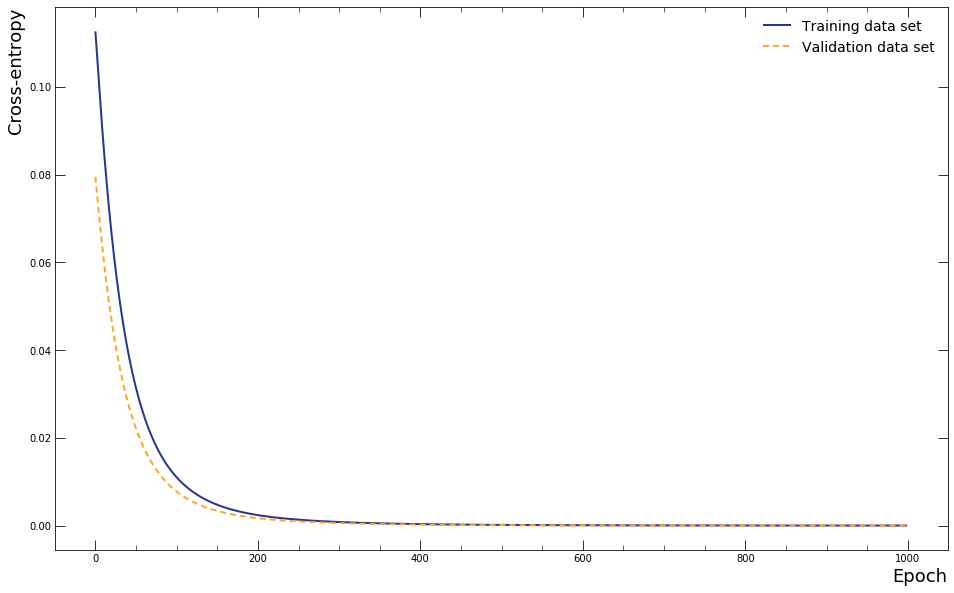

In [10]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

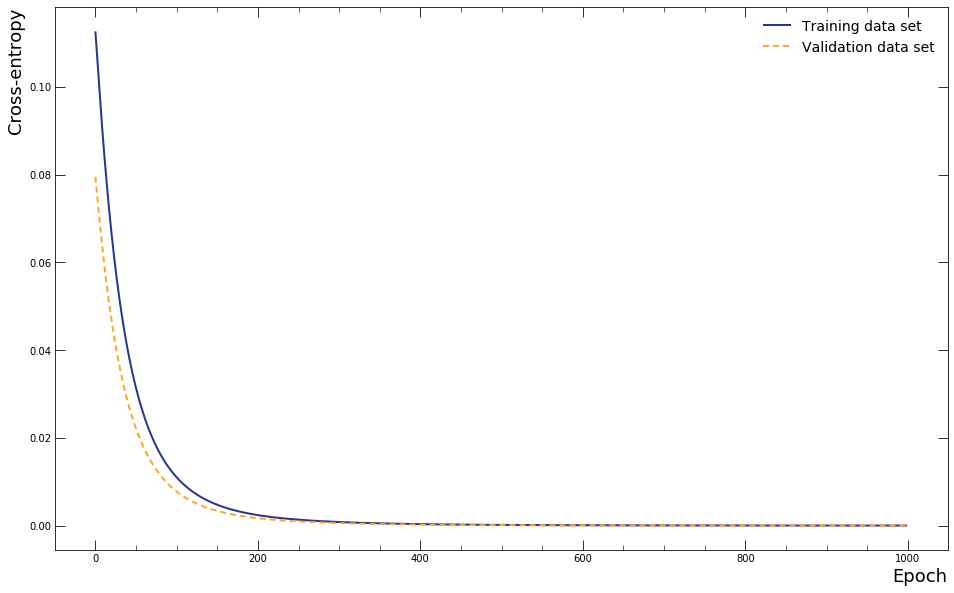

In [11]:
plot_loss(history)

## Training Set

In [12]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train_new))

error = abs(x_train_new-reconstructed)/x_train_new

In [13]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

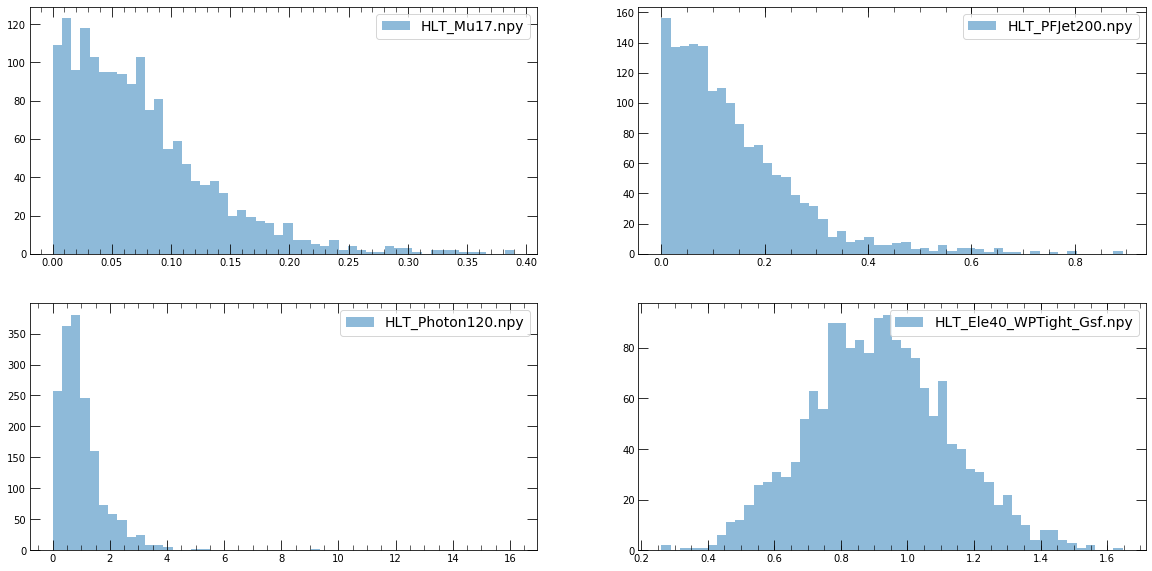

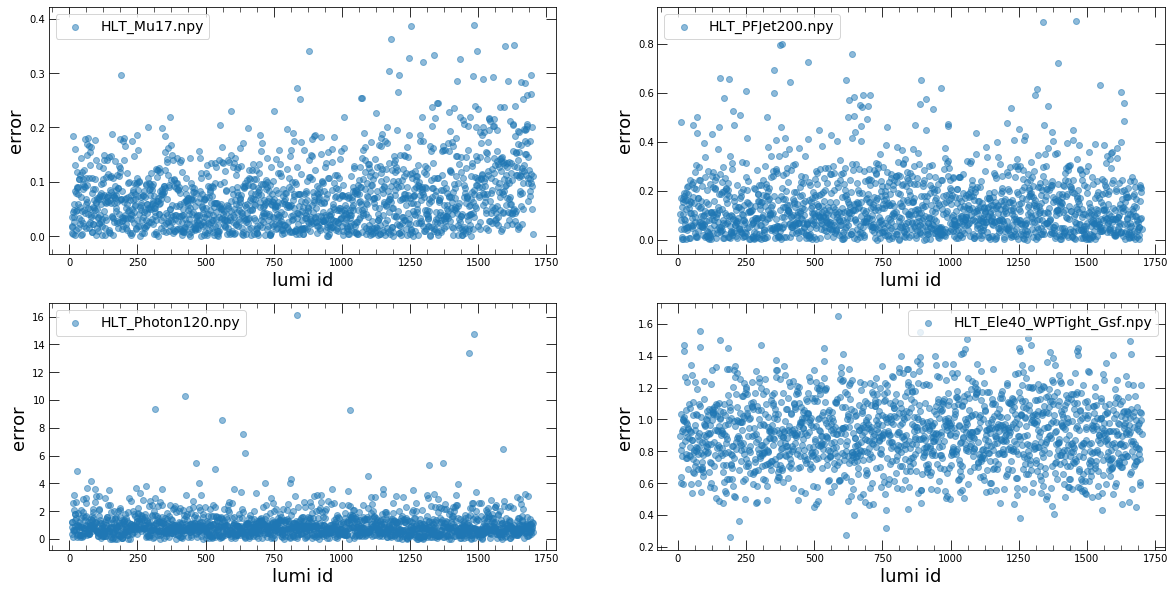

In [14]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

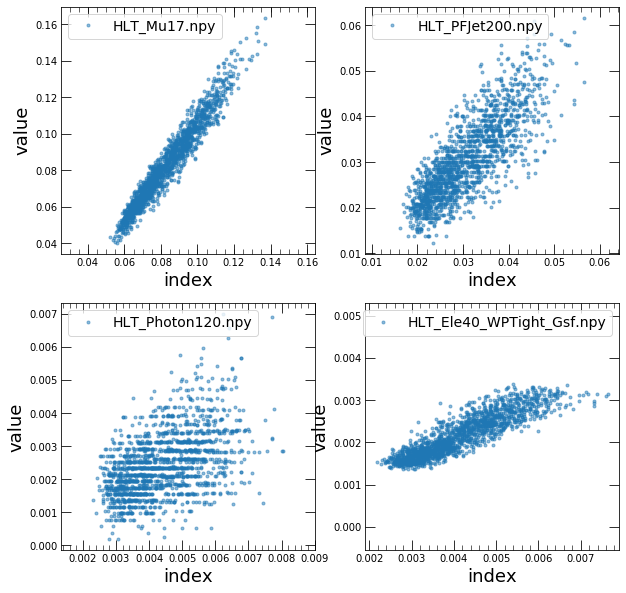

In [15]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [16]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [17]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

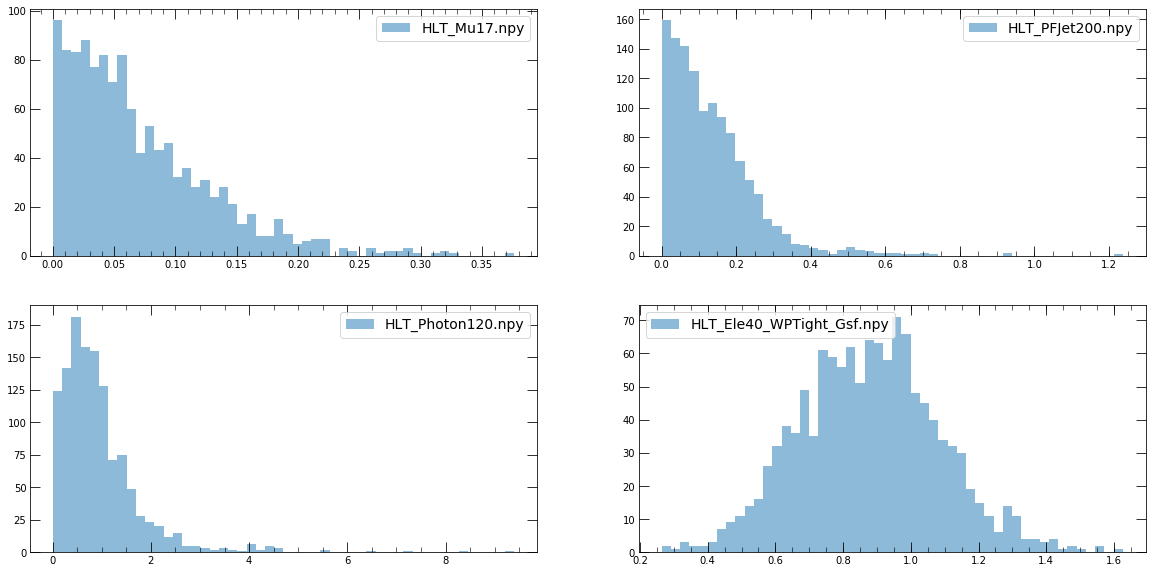

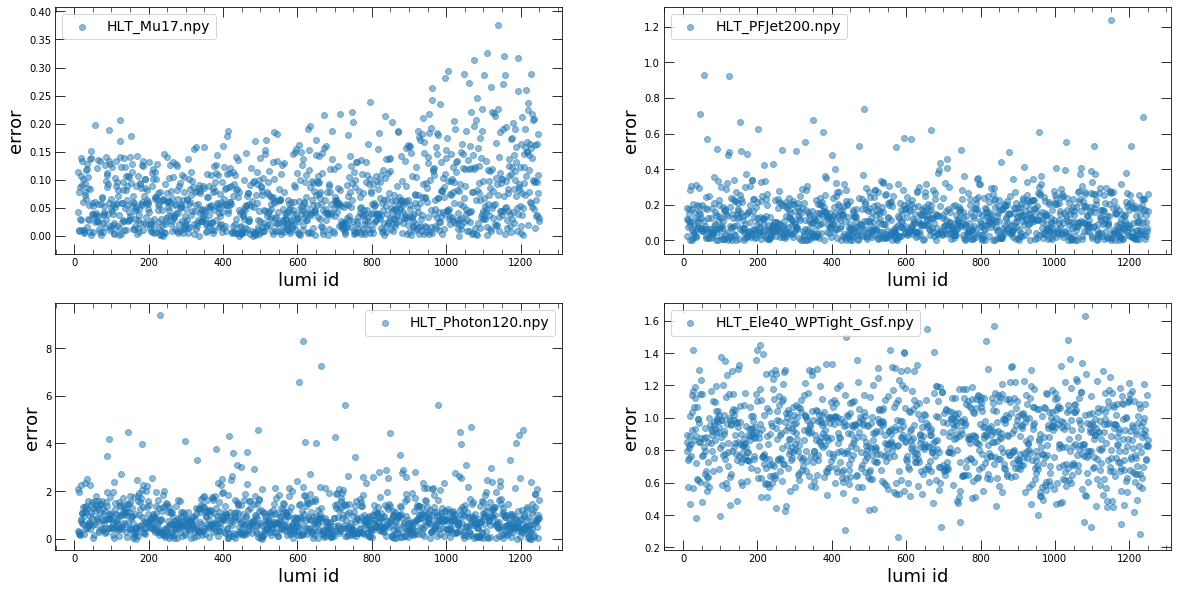

In [18]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

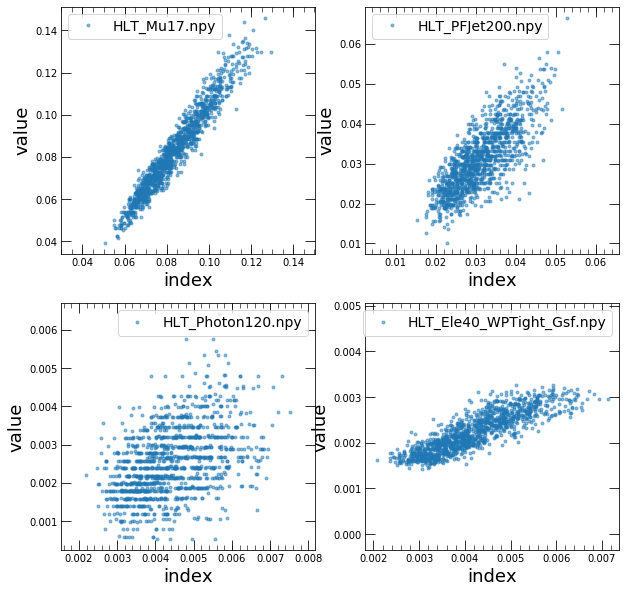

In [19]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [20]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [21]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [22]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [23]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [24]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


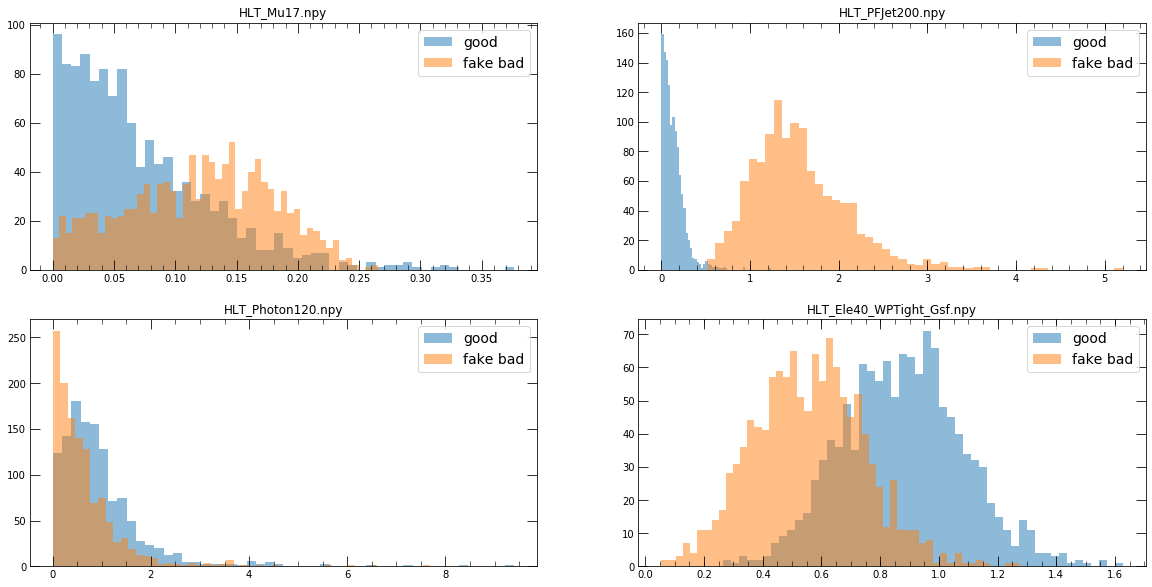

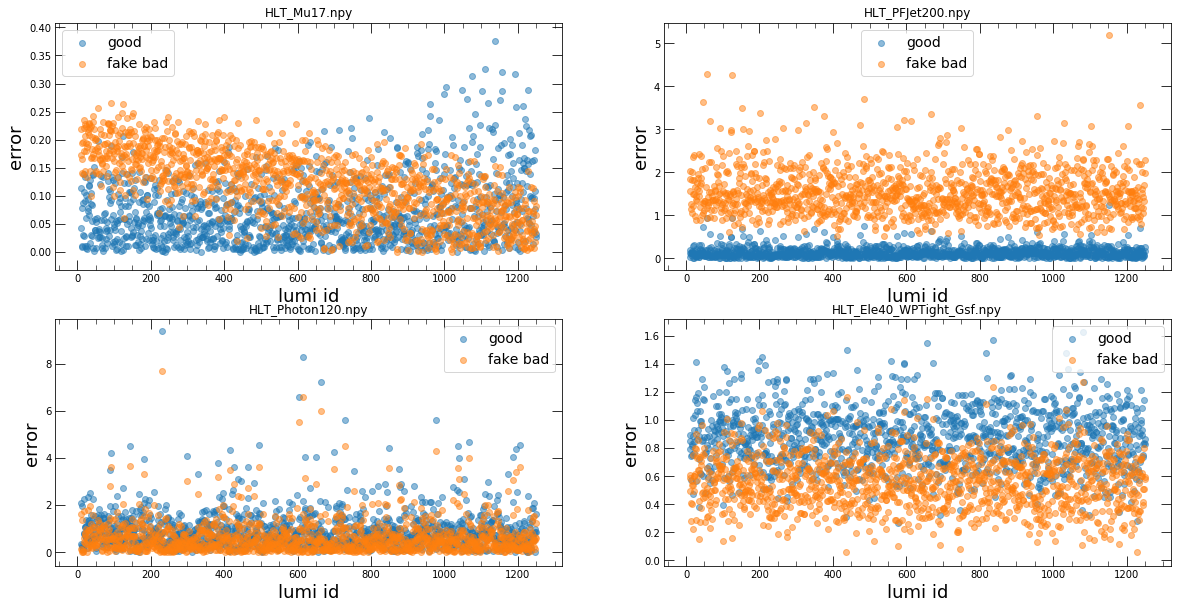

In [25]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

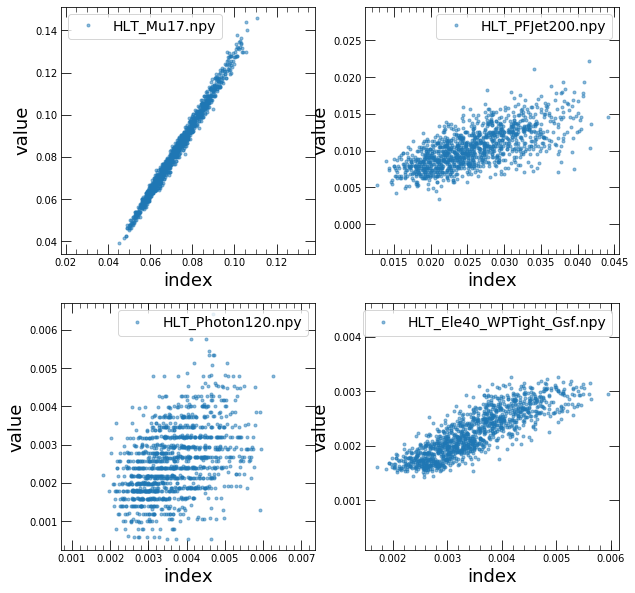

In [26]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    

plt.show()

In [27]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [28]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [29]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [30]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [31]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


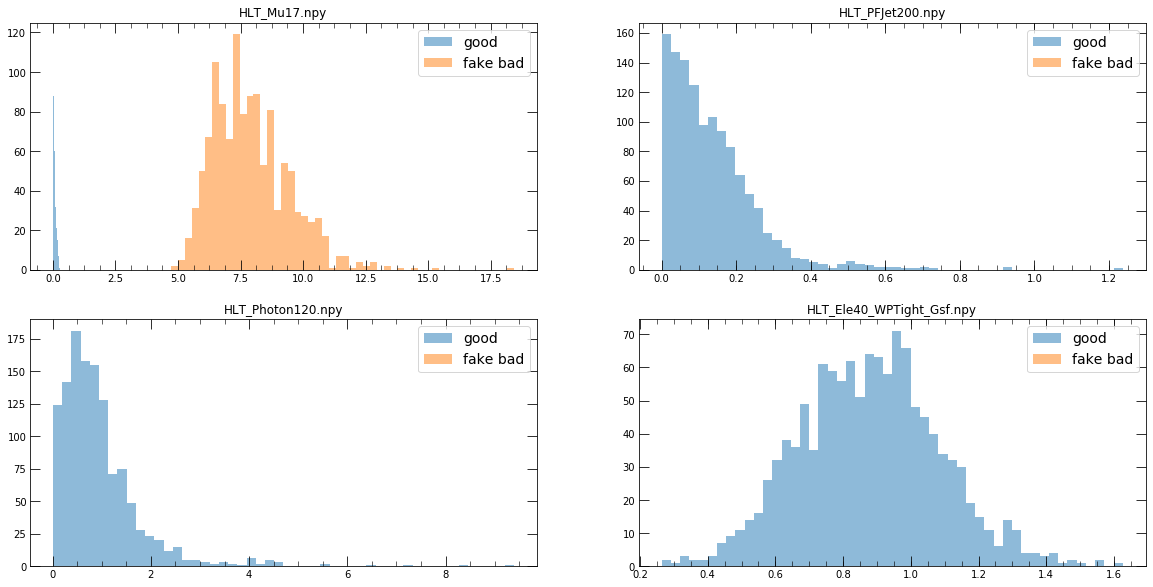

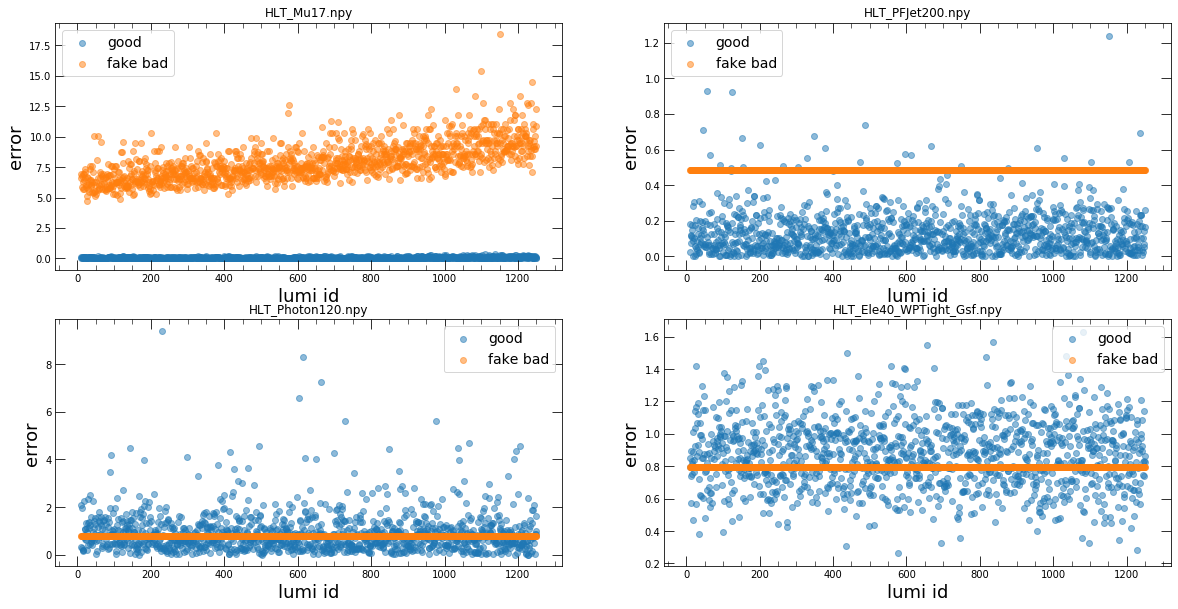

In [32]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

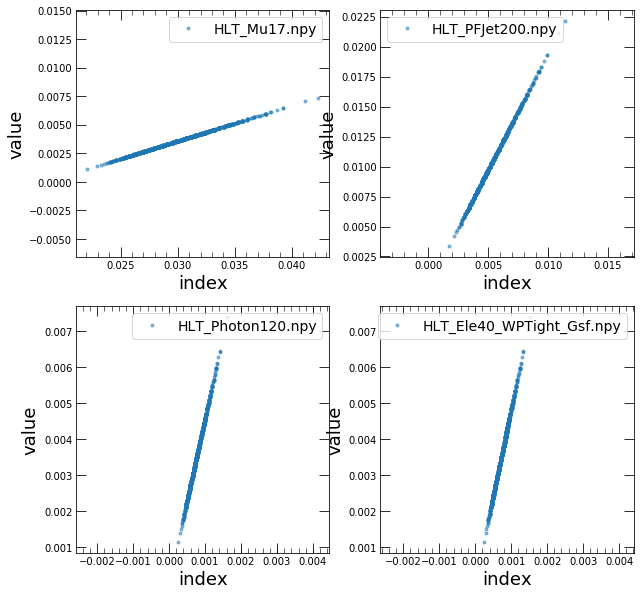

In [33]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [34]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [35]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [36]:
bad_runs = [301480]

with open("bad_data_CNorm" + str(cnorm) + ".pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [37]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [38]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


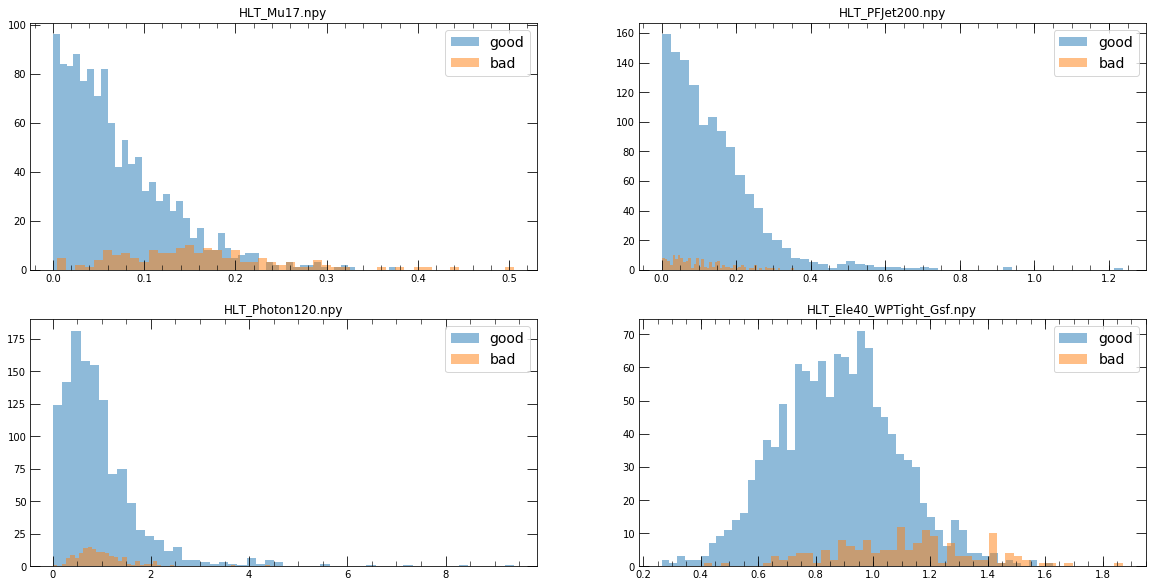

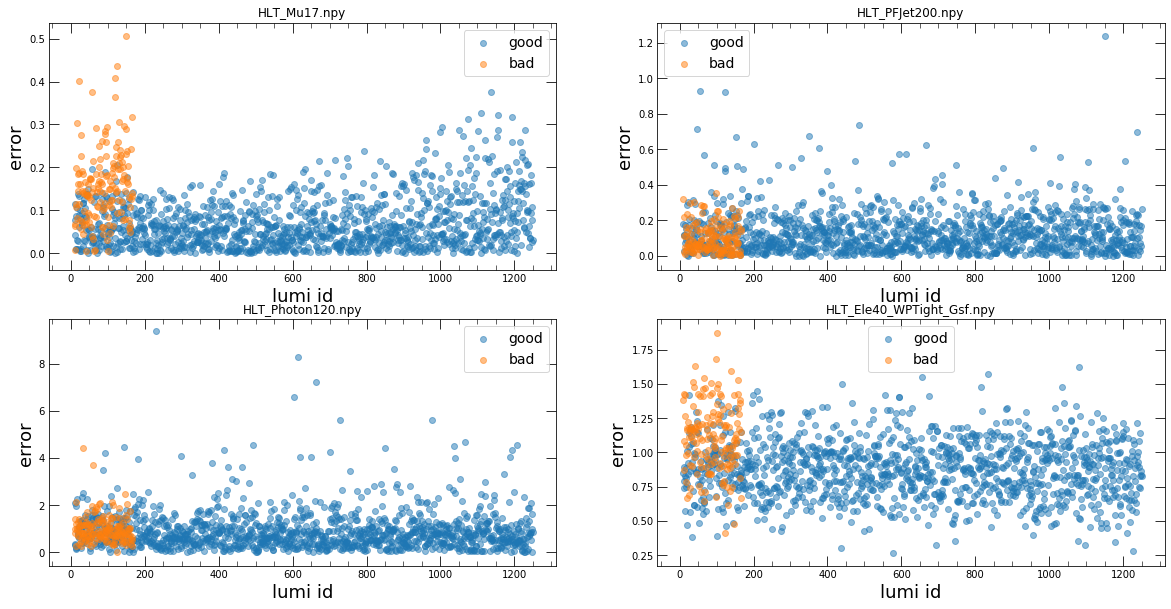

In [39]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

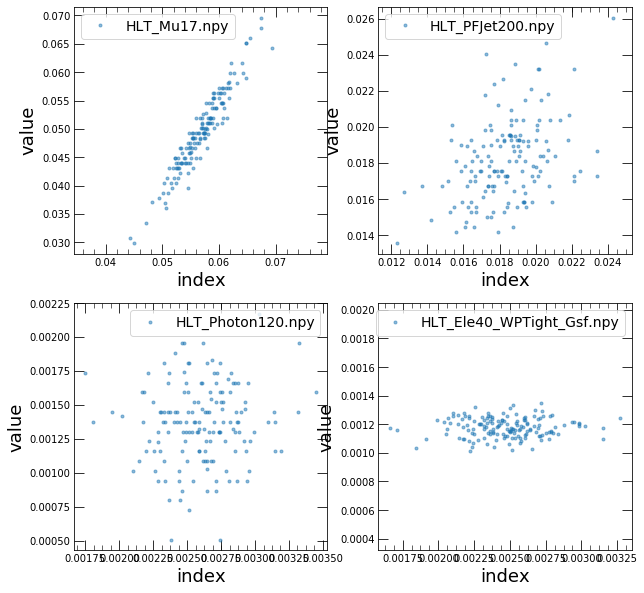

In [40]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [41]:
bad_runs = [305588]

with open("bad_data_CNorm" + str(cnorm) + ".pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [42]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [43]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


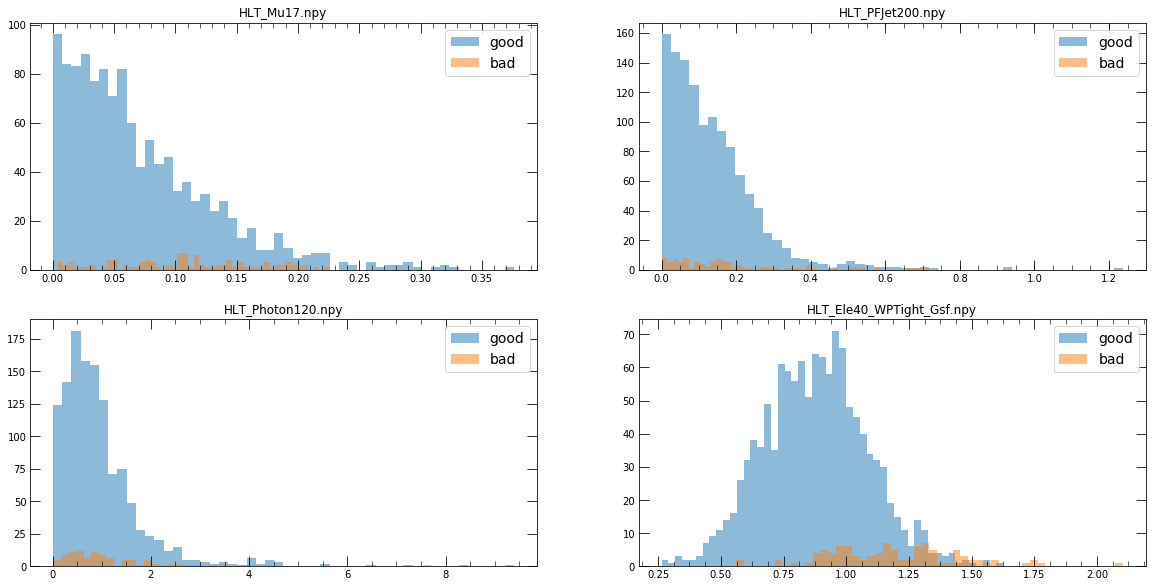

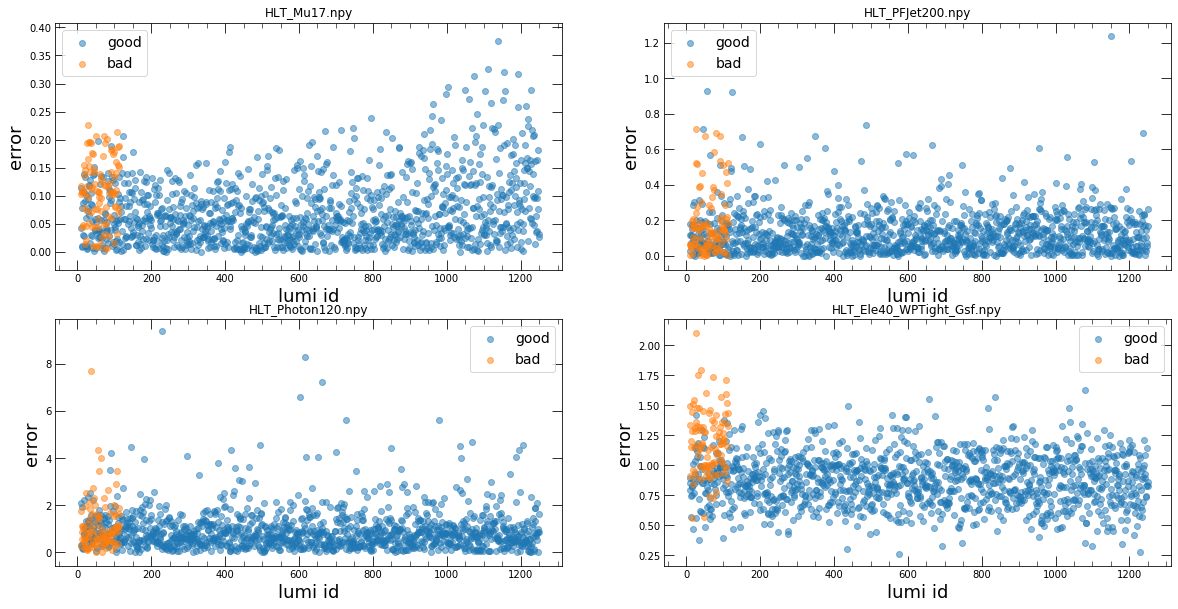

In [44]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

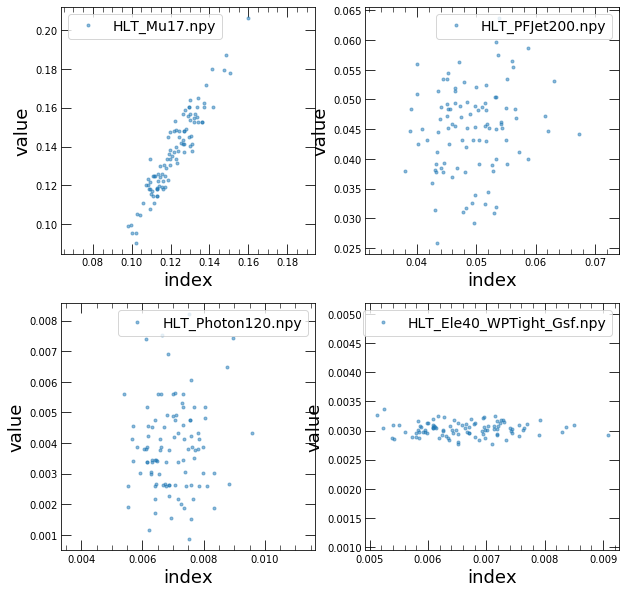

In [45]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()